# Linear Regression Demo  
Using the `rice2025` Machine Learning Package

This notebook demonstrates:

- Loading and cleaning the Student Performance dataset  
- Exploratory Data Analysis (EDA)  
- Training a Linear Regression model implemented from scratch  
- Evaluating model performance without using `sklearn`  
- Visualizing residuals and feature importance  
- Using custom utilities (`train_test_split`) and metrics  


## Mathematical Intuition Behind Linear Regression

Linear regression models the relationship between a continuous target variable and a set of input features by assuming a **linear functional form**. The goal is to estimate how changes in each feature affect the expected value of the response.

### Model Specification

Let $X \in \mathbb{R}^{n \times p}$ be the design matrix, where:
- $n$ is the number of observations,
- $p$ is the number of features,
- each row corresponds to one data point.

Let $y \in \mathbb{R}^n$ be the target vector.

The linear regression model assumes:
$$
y = X\beta + \varepsilon
$$
where:
- $\beta \in \mathbb{R}^p$ is the vector of regression coefficients,
- $\varepsilon$ is a noise term with $\mathbb{E}[\varepsilon] = 0$.

Including an intercept term, the model can be written as:
$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} + \varepsilon_i
$$

### Least Squares Objective

Linear regression estimates the coefficients by minimizing the **sum of squared residuals**:
$$
\min_{\beta} \; \sum_{i=1}^n (y_i - \hat{y}_i)^2
= \min_{\beta} \; \| y - X\beta \|_2^2
$$

This is known as the **ordinary least squares (OLS)** problem.

### Closed-Form Solution (Normal Equation)

Assuming $X^\top X$ is invertible, the optimal solution has a closed form:
$$
\hat{\beta} = (X^\top X)^{-1} X^\top y
$$

The `rice2025` implementation computes this solution directly rather than using iterative optimization or external libraries.

### Interpretation of Coefficients

Each coefficient $\beta_j$ represents the **expected change in the target variable** for a one-unit increase in feature $x_j$, holding all other features constant:
- Positive $\beta_j$: feature increases the predicted outcome
- Negative $\beta_j$: feature decreases the predicted outcome
- Larger magnitude: stronger linear influence

The intercept $\beta_0$ represents the baseline prediction when all features are zero.

### Residuals

For each observation, the **residual** is:
$$
r_i = y_i - \hat{y}_i
$$

Residuals capture the portion of the target not explained by the linear model. Diagnostic plots of residuals are used to assess whether the model assumptions are reasonable.

### Model Assumptions

Linear regression relies on the following assumptions:
- **Linearity**: the relationship between features and target is linear
- **Independence**: observations are independent
- **Homoscedasticity**: residuals have constant variance
- **Normality (optional)**: residuals are approximately normally distributed (mainly for inference)

The residual diagnostics in this notebook are used to empirically assess these assumptions.

### Performance Metrics

Model performance is evaluated using standard regression metrics:

- **Mean Squared Error (MSE)**:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

- **Root Mean Squared Error (RMSE)**:
$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

- **Mean Absolute Error (MAE)**:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

- **Coefficient of Determination ($R^2$)**:
$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

$R^2$ measures the proportion of variance in the target explained by the model.

### Summary

Linear regression frames prediction as a **least-squares optimization problem** with a clear geometric and statistical interpretation. Its simplicity, interpretability, and strong empirical performance make it a foundational tool for supervised learning and a natural baseline for more complex models.


## Setup and Dataset Loading

In this section, we import the necessary libraries and load the Student Performance dataset.
This dataset contains academic and behavioral attributes such as hours studied,
previous exam scores, sleep habits, and extracurricular activities.  
Our goal is to predict **Performance Index**, a measure of overall student performance.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice2025.supervised_learning.linear_regression import LinearRegression
from rice2025.utils.train_test_split import train_test_split

# Load CSV using python engine for maximum compatibility
df = pd.read_csv("Student_Performance.csv", engine="python")

# Clean column names (removes hidden spaces, BOM, weird characters)
df.columns = (
    df.columns
      .astype(str)
      .str.strip()
      .str.replace("\ufeff", "", regex=False)
)



df["Extracurricular Activities"] = (
    df["Extracurricular Activities"]
      .astype(str)
      .str.strip()
      .str.lower()
      .map({"yes": 1, "no": 0})
)

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


# Exploratory Data Analysis (EDA)

Before fitting a linear regression model, it is important to understand the
structure and patterns in the dataset. In this section, we:

- Inspect dataset structure
- Visualize distributions of features
- Explore pairwise relationships
- Examine correlations with the target variable  
- Identify potential linear relationships relevant to regression

This helps determine whether the assumptions of linear regression are reasonable
and highlights which features are likely to be informative predictors.


<Figure size 1200x800 with 0 Axes>

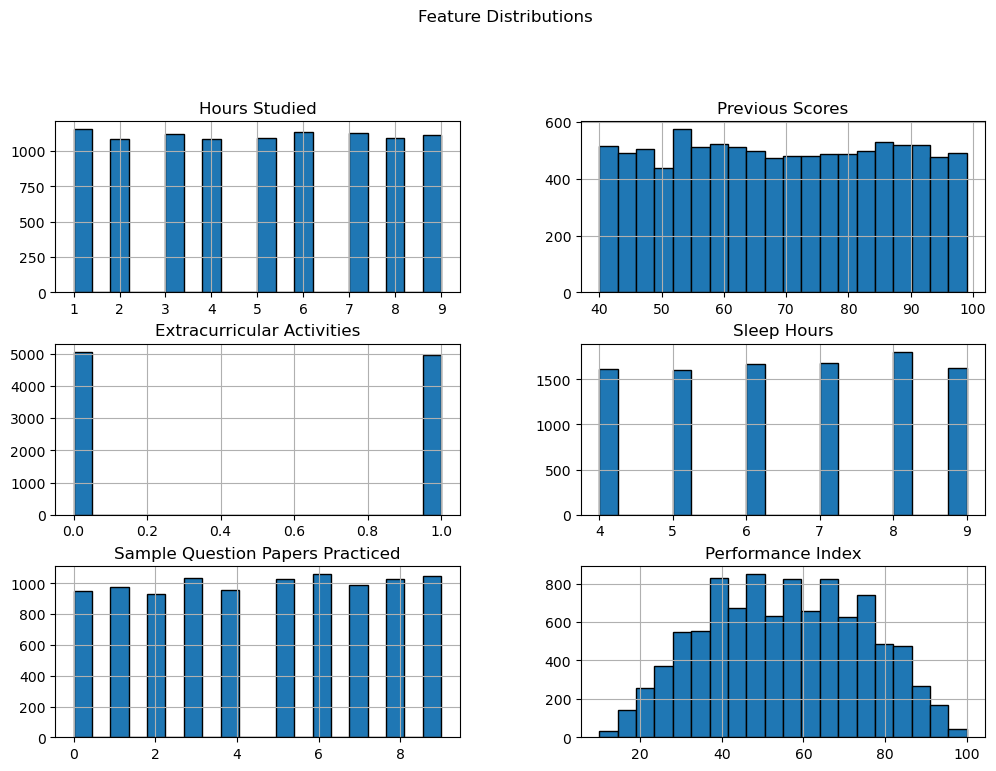

In [9]:
plt.figure(figsize=(12, 8))
df.hist(bins=20, figsize=(12, 8), edgecolor="black")
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


## Pairwise Feature Relationships

The pairplot below visualizes how each feature relates to the others and to the
target variable. Strong linear relationships may indicate good predictive
potential for linear regression.


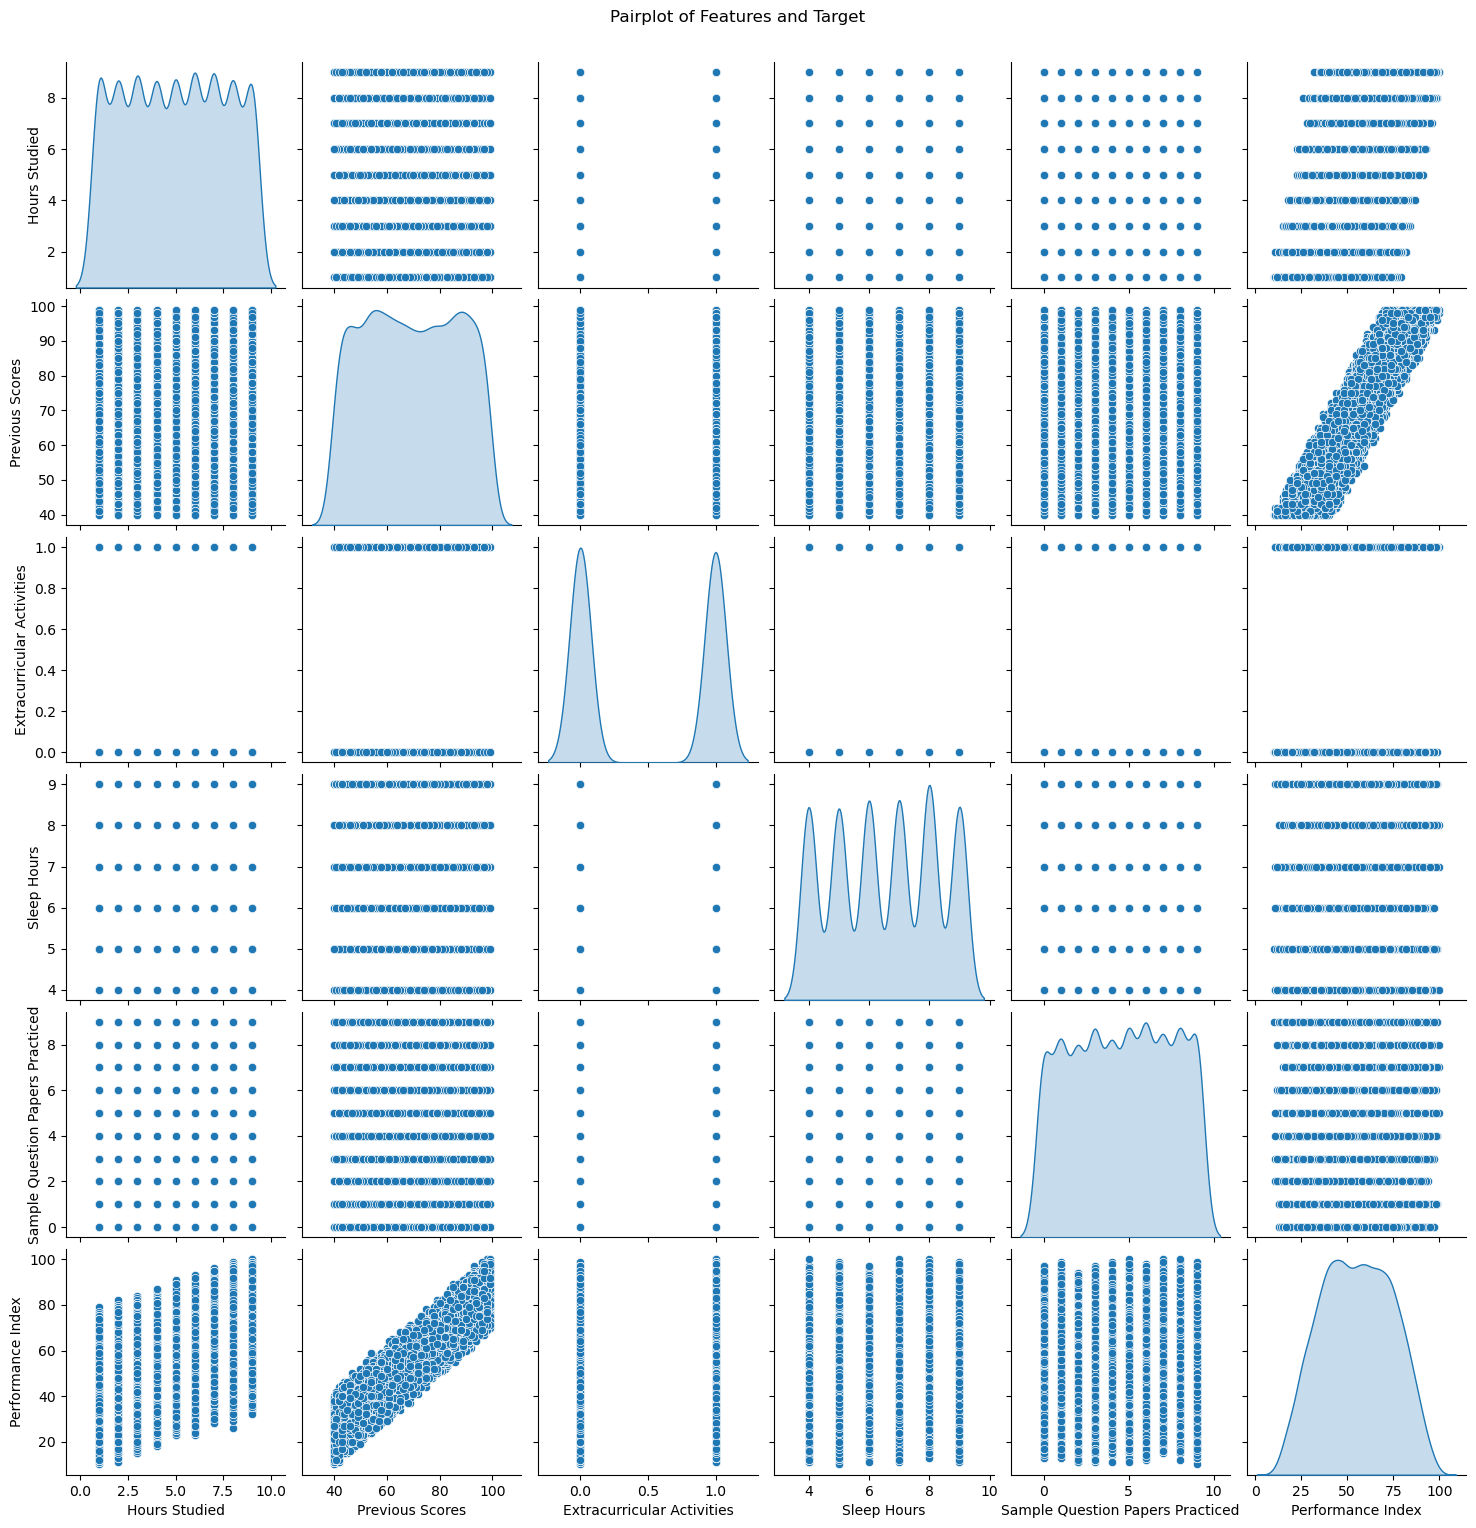

In [10]:
sns.pairplot(df, diag_kind="kde")
plt.suptitle("Pairplot of Features and Target", y=1.02)
plt.show()


## Correlation Analysis

The correlation matrix highlights how strongly each feature is associated with
the target variable (*Performance Index*). Features with strong positive or
negative correlation may be particularly useful in a linear model.


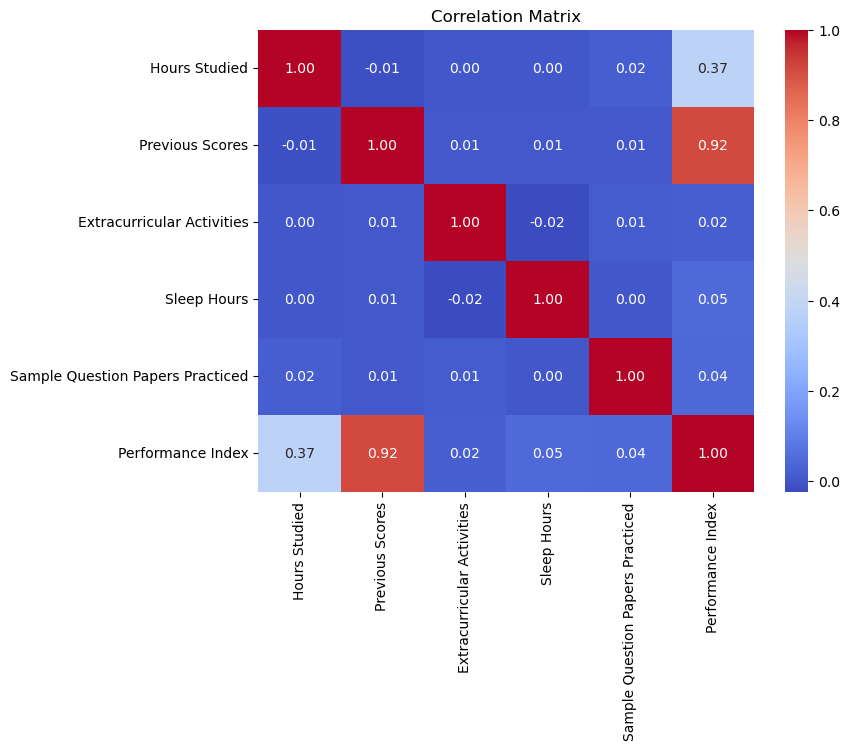

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## EDA Summary

The exploratory analysis suggests:

- **Hours Studied** and **Previous Scores** show clear linear relationships with Performance Index.
- **Extracurricular Activities** may have a weaker linear relationship but still contributes information.
- **Sleep Hours** and **Question Papers Practiced** show moderate correlations.
- No major missing data issues were identified.
- Distributions appear reasonably well-behaved for linear regression.

We now proceed to training a custom Linear Regression model using the
`rice2025` package.


## Selecting Features and Target Variable

We select the following variables as predictors of academic performance:

- **Hours Studied** — amount of study time  
- **Previous Scores** — performance in earlier assessments  
- **Extracurricular Activities** — level of outside engagement  
- **Sleep Hours** — sleep duration, which affects cognitive performance  
- **Sample Question Papers Practiced** — extent of exam preparation  

The variable **Performance Index** is used as the target (the value we want to predict).


In [7]:
features = [
    "Hours Studied",
    "Previous Scores",
    "Extracurricular Activities",
    "Sleep Hours",
    "Sample Question Papers Practiced"
]

X = df[features].values
y = df["Performance Index"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((8000, 5), (2000, 5))

## Training the Linear Regression Model

We now fit the linear regression model using our custom implementation.
By default, the model uses the **closed-form normal equation**, which computes
the optimal parameters directly.

This step learns:

- The **intercept** (baseline performance level)
- The **coefficients** for each feature, indicating how strongly each variable influences performance


In [8]:
model = LinearRegression()
model.fit(X_train, y_train)
model.summary(X_test, y_test)


Model Summary
----------------------------------------
Intercept: -34.132271857022374
Coefficients: [2.860414   1.01837681 0.637999   0.48185709 0.19520094]
R² Score: 0.9885
MSE: 4.1796
RMSE: 2.0444
MAE: 1.6394
----------------------------------------


# Visualizing Model Fit

After training the linear regression model, it is useful to visualize how well
the predictions align with the true performance values. Because this is a
multiple linear regression model (with several features), we cannot plot a
single regression line. Instead, we use two key visualizations:

- **Actual vs Predicted Plot** — shows overall predictive accuracy  
- **Residual Diagnostics** — reveals whether linear regression assumptions hold  

These plots help confirm whet


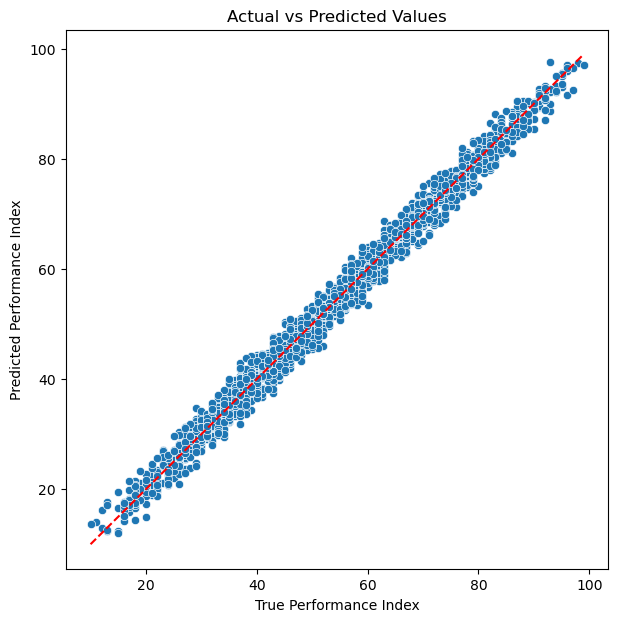

In [16]:
y_pred = model.predict(X_test)

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)],
         color="red", linestyle="--")
plt.xlabel("True Performance Index")
plt.ylabel("Predicted Performance Index")
plt.title("Actual vs Predicted Values")
plt.show()


## Interpretation

- The **Actual vs Predicted** plot shows predictions are tightly aligned along
  the diagonal, indicating strong model accuracy.


# Residual Diagnostics

Residual analysis helps determine whether the linear regression model assumptions
are reasonable. A good model should produce residuals that:

- Are centered around zero  
- Show no clear pattern or curvature  
- Have constant variance  
- Are approximately normally distributed  

We now visualize the residuals using multiple diagnostic plots.


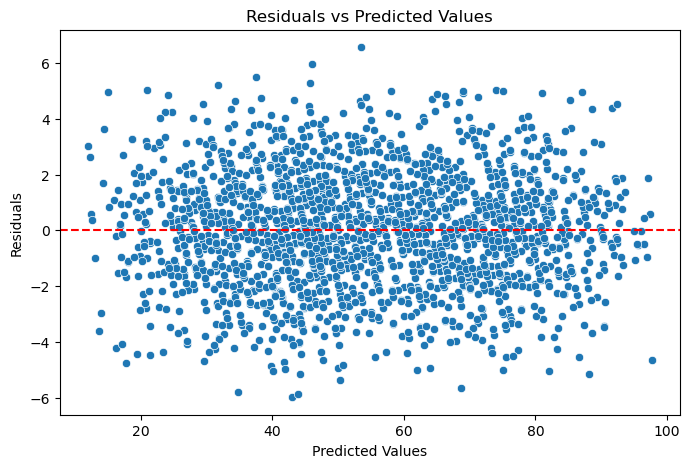

In [13]:
model.plot_residuals(X_test, y_test)


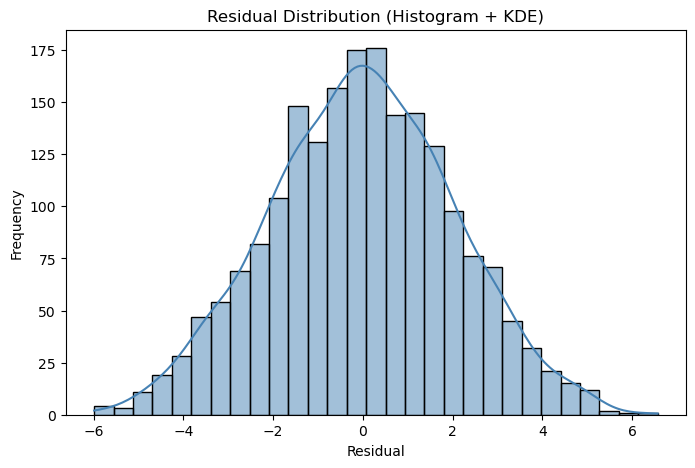

In [14]:
res = model.residuals(X_test, y_test)

plt.figure(figsize=(8,5))
sns.histplot(res, kde=True, color="steelblue")
plt.title("Residual Distribution (Histogram + KDE)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


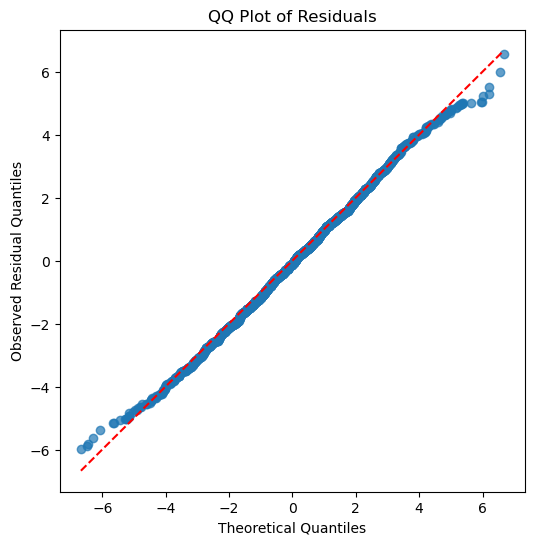

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Manual QQ-plot implementation (no scipy)
sorted_res = np.sort(res)
n = len(res)
theoretical_q = np.sort(np.random.normal(loc=0, scale=np.std(res), size=n))

plt.figure(figsize=(6,6))
plt.scatter(theoretical_q, sorted_res, alpha=0.7)
plt.plot([theoretical_q.min(), theoretical_q.max()],
         [theoretical_q.min(), theoretical_q.max()],
         color="red", linestyle="--")
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Observed Residual Quantiles")
plt.show()


## Interpretation of the Residual Diagnostics

- **Residuals vs Predicted:** Should show a random cloud. Patterns indicate nonlinearity.
- **Histogram/KDE:** Residuals appear roughly (but not perfectly) normal.
- **QQ Plot:** Deviations from the diagonal indicate departures from normality.
- **Actual vs Predicted:** Points close to the diagonal line indicate strong predictive accuracy.
- **Residuals vs Features:** Helps diagnose nonlinearity or heteroskedasticity for specific predictors.

Overall, the diagnostic plots support the validity of using a linear regression
model, with no severe violations of model assumptions.
